In [ ]:
# ..... join metacells into clusters ..... #
# all reciprocal top hits and auroc > 0.95 in all vs all mode

In [2]:
library(igraph)

In [82]:
currstage = 'stage23'
load(paste0(currstage, '_metacell_MN.Rdata'))
ls()

[1] "alltypes"           "aurocs1v1"          "aurocsall"         
 [4] "c1"                 "c2"                 "celltypes"         
 [7] "cmat"               "cmat2"              "ctypes"            
[10] "currstage"          "g"                  "g2"                
[13] "ii"                 "integrate_outliers" "match_all"         
[16] "newdf"              "numround"           "outliers"          
[19] "outliers_all"       "temp"               "topdf"             
[22] "topdf2"             "topn"

[1] 2 2 3 2 4 2 6 3 5 3 5 2 3 2 2 8 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

[1] 33

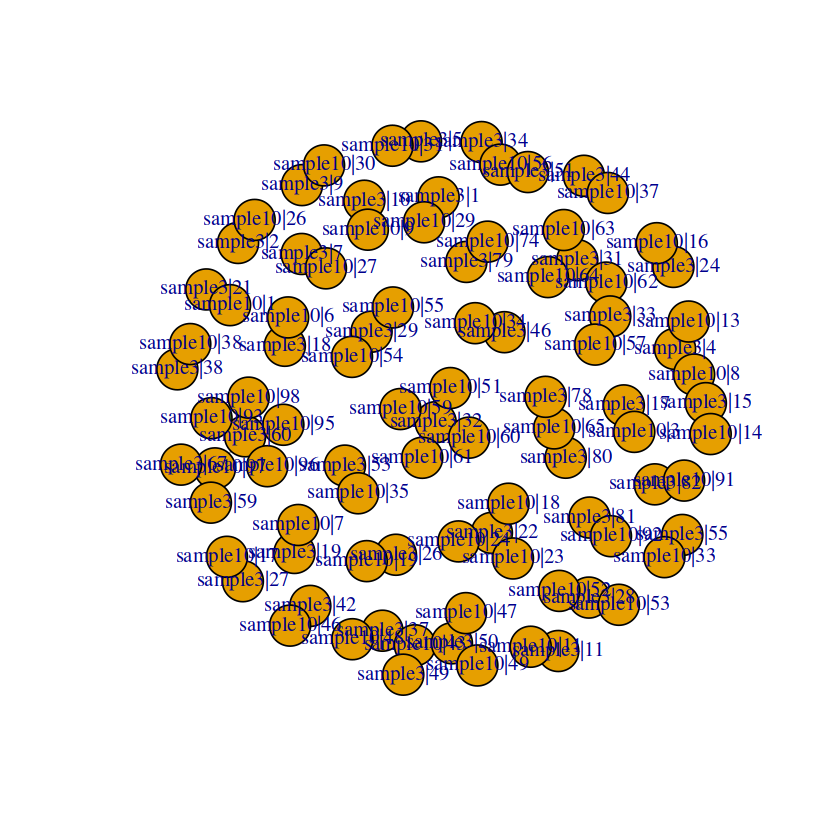

In [83]:
# initial graph from topdf
g <- graph.data.frame(topdf, directed=FALSE)
plot(g)
components(g)$csize
components(g)$no

In [97]:
# get initial matchign of metacells
newdf = data.frame(metacell = names(components(g)$membership), 
                   cluster = paste0('cluster_', components(g)$membership))
newdf$map_type = 'Reciprocal_auroc_0.95'
rownames(newdf) = NULL
head(newdf)

metacell   cluster   map_type             
1 sample3|81 cluster_1 Reciprocal_auroc_0.95
2 sample3|82 cluster_2 Reciprocal_auroc_0.95
3 sample3|28 cluster_3 Reciprocal_auroc_0.95
4 sample3|21 cluster_4 Reciprocal_auroc_0.95
5 sample3|22 cluster_5 Reciprocal_auroc_0.95
6 sample3|7  cluster_6 Reciprocal_auroc_0.95

In [85]:
ctypes = newdf$metacell
alltypes = rownames(aurocsall)
outliers_all = setdiff(alltypes, ctypes)
length(ctypes)
length(alltypes)
length(outliers_all)

[1] 93

[1] 190

[1] 97

In [98]:
# get consensus clusters
integrate_outliers <- function(cluster1, outl, fullmatall, n){
    cluster2 = cluster1
    
    for(ii in 1:length(outl)){
        curroutl = outl[ii]
        id1 = match(curroutl, colnames(fullmatall))
        list1 = sort(fullmatall[,id1], decreasing = T)[1:n]  # get top 10 incl itself    

        tout1 = table(cluster1$cluster[match(names(list1), cluster1$metacell)])
        
        if(tout1[which.max(tout1)]>=3){
#             print(paste0(curroutl, ' : ', names(tout1)[which.max(tout1)]))
            temp = data.frame(metacell = curroutl,
                              cluster = names(tout1)[which.max(tout1)][1],
                             map_type = paste0('majority_top_', n))
            cluster2 = rbind(cluster2, temp)
        }
    }
    return(cluster2)
}

In [99]:
# round 'n', do upto as many rounds and see when converges
# iterative procedure to update cross_sample metacell mapping

# clusters tend to group with already dense cross-species clusters, rather than with
# smaller clusters (with fewer clusters and/or species)
topn = c(10, 10, 10, 20, 20, 20)
for(numround in 1:6){
    
    ctypes = newdf$metacell
    outliers = setdiff(alltypes, ctypes)
    
    if(length(outliers)){
        newdf = integrate_outliers(newdf, outliers, aurocsall, topn[numround])

        print(paste0(numround, ' : ', length(outliers), '  ', 
                     length(alltypes) - dim(newdf)[1]))                     
    }
}

[1] "1 : 97  20"
[1] "2 : 20  11"
[1] "3 : 11  9"
[1] "4 : 9  2"
[1] "5 : 2  1"
[1] "6 : 1  0"


[1]  2  2  3  2  8  2  9  3  5  3 22  2 27  2  2 38 26  2  2  2  2  2  2  2  2
[26]  2  2  2  2  2  2  2  2

[1] 33

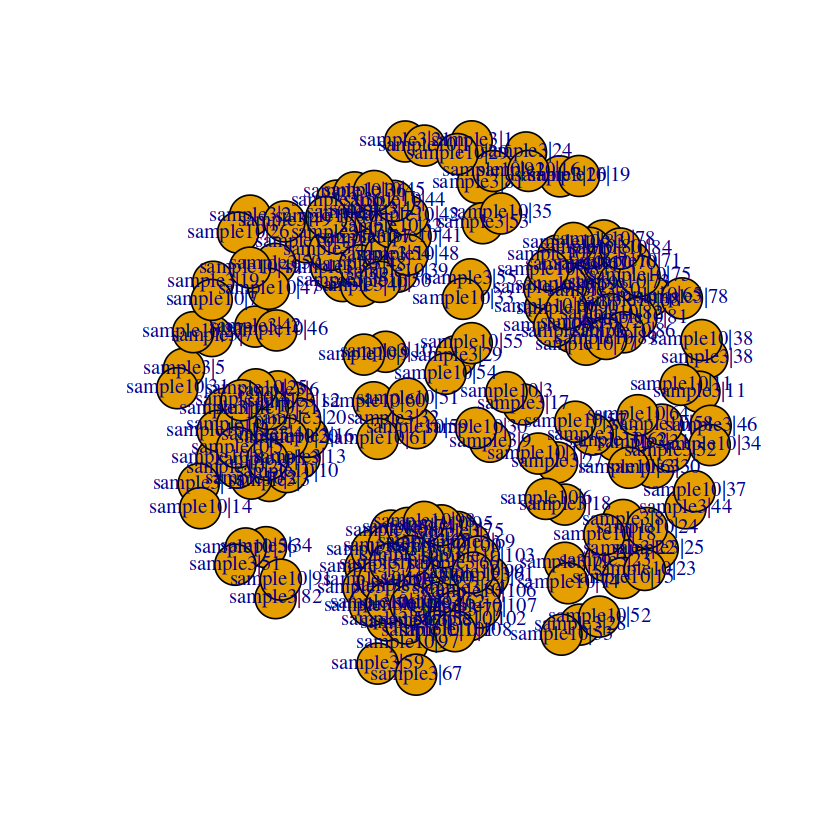

In [100]:
# final graph from topdf
match_all = newdf$metacell[match(newdf$cluster[match(outliers_all, newdf$metacell)], newdf$cluster)]
temp = data.frame(outliers_all, match_all, rep(NA, length(outliers_all)), rep('majority_topN', length(outliers_all)))
colnames(temp) = colnames(topdf)

topdf2 = rbind(topdf, temp)
g2 <- graph.data.frame(topdf2, directed=FALSE)
plot(g2)
components(g2)$csize
components(g2)$no

In [101]:
# visualize final clustering
pdf(paste0('aa-', currstage,'-graph.pdf'), width = 10, height = 10)
plot(g2, vertex.size = 10)
dev.off()

png 
  2

In [102]:
# save newdf for final cluster list, topdf2 for igraph plot
write.table(newdf, file = paste0(currstage, '_metacell_to_cluster.csv'), sep = ',',
           row.names = F, col.names = T, quote = F)
write.table(topdf2, file = paste0(currstage, '_cluster_graphdf.csv'), sep = ',',
           row.names = F, col.names = T, quote = F)

In [ ]:
# ..... plotting graph ..... #

In [33]:
currstage = 'stage32'
topdf2 = read.delim(paste0(currstage, '_cluster_graphdf.csv'), sep = ',')
ctypes = union(unlist(topdf2[,1]), unlist(topdf2[,2]))

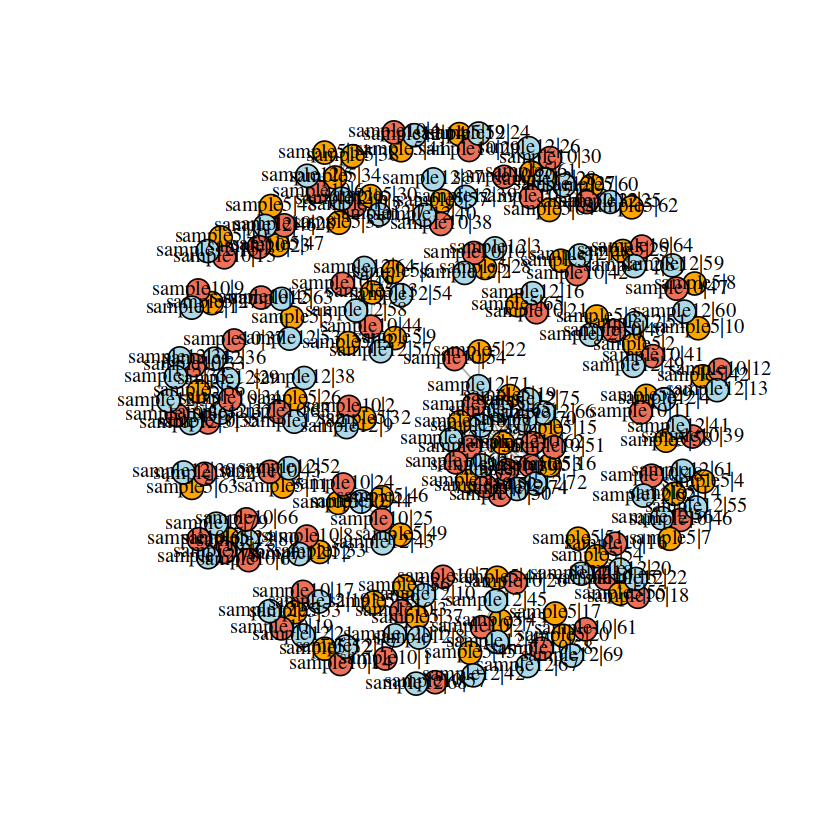

In [35]:
answers = data.frame(celltype = ctypes, sample = sub('\\|.*', '', ctypes), color = 'orange')
smp = unique(answers$sample)
answers$color[answers$sample==smp[2]] = '#ed7059'
answers$color[answers$sample==smp[3]] = 'lightblue'

g2 <- graph.data.frame(topdf2, vertices = answers, directed=FALSE)

# visualize final clustering
# pdf(paste0('aa-', currstage,'-graph.pdf'), width = 20, height = 20)
plot(g2, vertex.size = 8, vertex.label.color = 'black')
# dev.off()